In [1]:
import numpy as np

import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,IFrame,HTML,Image

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
url='https://www.janestreet.com/puzzles/knight-moves-5-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n"+" \n ".join(y[10:68])))
display(Image(url='https://www.janestreet.com/puzzles/20231101_knight_moves_5.png',width=500))

### Archive
Intro 
 Current Puzzle 
 Archive 
 Knight Moves 5 
 November 2023 : Puzzle 
 Show Solution 
 An 8-by-8 “lattice” is represented above. A knight arrives at 
 a1 
 at time 
 T 
 =0, and wishes to travel to the upper-right corner ( 
 h8 
 ). This lattice respresents a 
 3-dimensional landscape 
 ; the numbers at each “point” represent their 
 altitudes 
 . 
 But there’s a big problem here, which is that this grid was built on a swamp, and the lattice points are prone to 
 sinking 
 . Whenever the knight arrives on a lattice point of altitude 
 A 
 , that point and 
 all others with the same altitude 
 start sinking at the rate of 1 unit per 
 n 
 minutes, where 
 n 
 is the number of lattice points of altitude 
 A 
 . Furthermore, the lattice point 
 diametrically opposite 
 the one the knight is on 
 rises 
 at the rate of 1 unit per 
 n 
 minutes. This sinking (and rising) continues only while the knight remains stationary, which may be for as much or as little time as the knight chooses. No other points move or begin to move during this time. (Altitudes can become negative. In the event that the “opposite” point is at the same initial altitude, it neither rises nor sinks, and is ignored for the purpose of calculating 
 n 
 .) 
 The knight is only allowed to make 3-dimensional jumps that are permutations of (0,±1,±2) – that is, jumps that move exactly 0 units in one dimension, exactly 1 unit in another, and exactly 2 units in the third. Jumps take 0 time to complete. In the spirit of a knight’s “tour”, your goal is to find the path to the upper-right corner that takes 
 as much time as possible 
 . Tours of 
 180 minutes or longer 
 are eligible for the leaderboard. 
 Updated 11/6: 
 Due to some shortsightedness on our part we forgot to include the following extra rule. All “sinks” in a tour must be 
 necessary 
 sinks. That is, if a jump ( 
 t, P 
 ) has 
 t 
 > 0, it 
 must 
 be the case that there exists a value 
 t’ 
 such that replacing ( 
 t, P 
 ) with ( 
 t’, P

In [3]:
# Very interesting. After a lot of time trying to workout an efficient way to prune a brute force search 
# I thought about the game a bit more deeply.
# To get to the end you need to keep a path open so can't drop every number
# plus you need to maintain a path to the end as well
# Once had realised this realised you drop either odds or evens down 2 increasing the numbers 
# leaving the other evens as a path to the end
# initially have to raise the corner to 15 to have a way to finish 
# and then it's just about moving round so you maximise then number of points dropped at each 
# stage while keeping a path open plus a fiddle about at the end


knight_moves = np.array([(-2, -1, 0), (-2, 1, 0), (2, -1, 0), (2, 1, 0),
                (-2, 0, -1), (-2, 0, 1), (2, 0, -1), (2, 0, 1),
                (-1, -2, 0),(-1, 2, 0), (1, -2, 0), (1, 2, 0),
                (-1, 0, -2),(-1, 0, 2), (1, 0, -2), (1, 0, 2),
                (0, -1, -2), (0, -1, 2), (0, 1, -2), (0, 1, 2), 
                (0, -2, -1), (0, -2, 1), (0, 2, -1), (0, 2, 1)])

grd2=np.array([[ 9,  8, 10, 12, 11,  8, 10, 17],
               [ 7,  9, 11,  9, 10, 12, 14, 12],
               [ 4,  7,  5,  8,  8,  6, 13, 10],
               [ 4, 10,  7,  9,  6,  8,  7,  9],
               [ 2,  6,  4,  2,  5,  9,  8, 11],
               [ 0,  3,  1,  4,  2,  7, 10,  7],
               [ 1,  2,  0,  1,  2,  5,  7,  6],
               [ 0,  2,  4,  3,  5,  6,  2,  4]],dtype=np.float64)

grid1=np.array([[11, 10, 11, 14],
                [ 8,  6,  9,  9],
                [10,  4,  3,  1],
                [ 7,  6,  5,  0]],dtype=np.float64)

In [4]:
# Some code to help visualise
def after_wait(grid,x,y,t):
    '''generate board after a wait of t at point x,y'''
    N=grid.shape[0]-1
    number_equal = np.sum(grid==grid[x,y])-(grid[N-x,N-y]==grid[x,y])
    increment = (-t/number_equal)
    grid += ((grid==grid[x,y])* increment)
    grid[N-x,N-y] += -increment
    return grid

def viz(grid,path,knight_moves=knight_moves,columns=4):
    '''visualise the path printing every grid'''
    cols = "abcdefgh"
    score = sum([n for n,(i,j) in path])
    print("Score is {:.0f}. Path {}".format(score,str([(n,cols[j]+str(grid.shape[0]-i))for n,(i,j) in path]).replace("'","")))
    X=columns
    N=grid.shape[0]-1
    tot = ((len(path)+1)//X)+1
    fig,ax = plt.subplots(tot,X,figsize=(20,20/X*tot))
    i,j = grid.shape[0]-1,0
    comment = "START"
    for n,shape in enumerate(path):
        a,b = n//X,n%X
        t,(x,y) = shape
        shade= np.zeros_like(grid)
        shade[i,j] = 2
        shade[N-i,N-j]=1
        sns.heatmap(shade,annot=grid,cbar=False,cmap="Greys",fmt="",linewidths=2,linecolor="lightgrey",ax=ax[a,b])
        
        ax[a,b].set_title(comment,fontsize =8)                                 
        grid = after_wait(grid,i,j,t)
        step =  [x-i,y-j,grid[x,y]-grid[i,j]]
        comment = str((t,cols[y]+str(grid.shape[0]-x)))+" similar {}. Move is {} valid =".format(np.sum(grid==grid[x,y]),step)+str(np.any([np.array_equal(step,k) for k in knight_moves]))
        i,j,u = x,y,t
        
    n+=1
    a,b = n//X,n%X
    shade= np.zeros_like(grid)
    shade[i,j] = 2
    shade[N-i,N-j]=1
    sns.heatmap(shade,annot=grid,cbar=False,cmap="Greys",fmt="0.2f",linewidths=2,linecolor="lightgrey",ax=ax[a,b])

    ax[a,b].set_title("END "+str(comment),fontsize =8)
    
    for i in range(tot*X):
        a,b = i//X,i%X
        ax[a,b].axis("off")

def viz2(grid,path,knight_moves=knight_moves,columns=4):
    '''visualise the path printing only the final grid'''
    cols = "abcdefgh"
    score = sum([n for n,(i,j) in path])
    print("Score is {:.0f}".format(score))
    i,j = grid.shape[0]-1,0
    N=grid.shape[0]-1
    for n,shape in enumerate(path): 
        t,(x,y) = shape
        grid = after_wait(grid,i,j,t)
        step =  [x-i,y-j,grid[x,y]-grid[i,j]]
        print(str((t,cols[y]+str(grid.shape[0]-x)))+" similar {}. Move is {} valid =".format(np.sum(grid==grid[x,y]),step)+str(np.any([np.array_equal(step,k) for k in knight_moves])))
        i,j,u = x,y,t        
    
    n+=1
    shade= np.zeros_like(grid)
    shade[i,j] = 2
    shade[N-i,N-j]=1
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax = sns.heatmap(shade,annot=grid,cbar=False,cmap="Greys",fmt="0.2f",linewidths=2,linecolor="lightgrey")
    ax.axis("off")
    nums,counts = np.unique(grid,return_counts=True)
    
    print({k:v for k,v in zip(nums,counts)})
   

Score is 28. Path [(0, a1), (1, b1), (0, a3), (0, a2), (0, b4), (5, a2), (3, c1), (2, d2), (0, c1), (15, d1), (1, d2), (0, c2), (1, b2), (0, b1), (0, b3), (0, c3), (0, c4), (0, a4), (0, b4), (0, d4)]


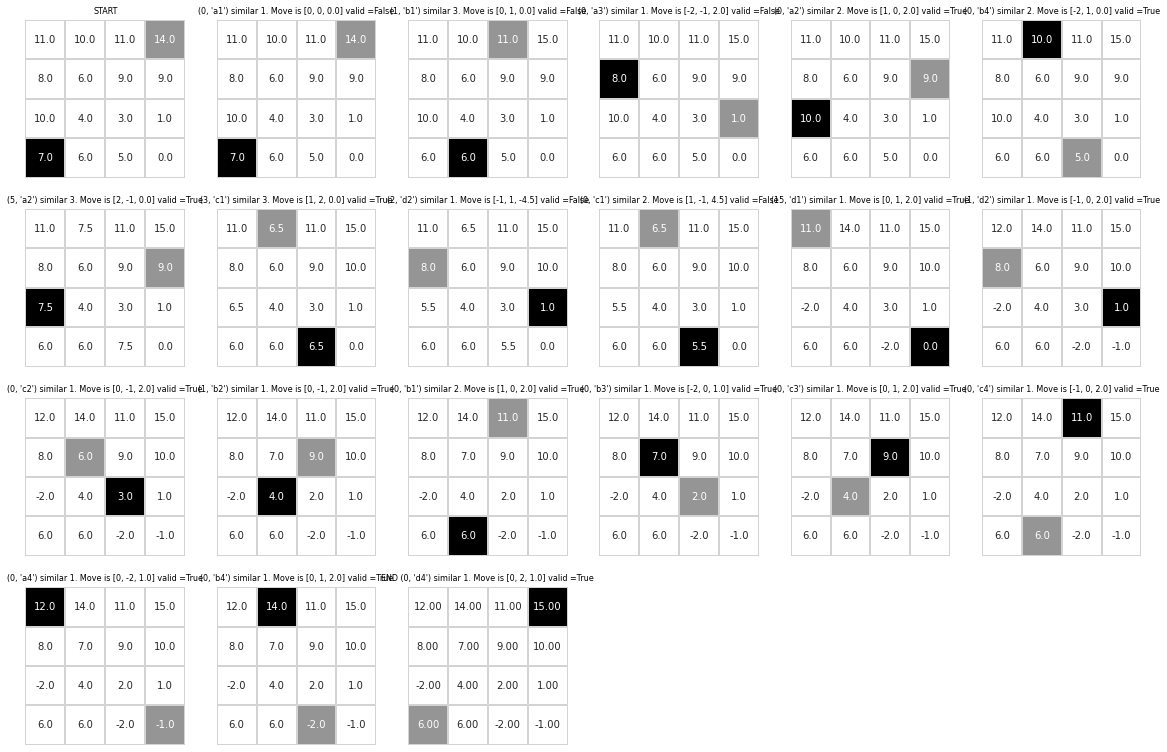

In [5]:
# test the code with the path given for the example

soln = [(0,(3,0)),(1,(3,1)),(0,(1,0)),(0,(2,0)),(0,(0,1)),(5,(2,0)),
        (3,(3,2)),(2,(2,3)),(0,(3,2)),(15,(3,3)),(1,(2,3)),
        (0,(2,2)),(1,(2,1)),(0,(3,1)),(0,(1,1)),(0,(1,2)),
        (0,(0,2)),(0,(0,0)),(0,(0,1)),(0,(0,3))]

viz(np.array(grid1),soln,columns=6)

Score is 180
(0, 'c2') similar 3. Move is [-1, 2, 0.0] valid =True
(0, 'a2') similar 3. Move is [0, -2, 1.0] valid =True
(9, 'a3') similar 3. Move is [-1, 0, 2.0] valid =True
(0, 'a4') similar 7. Move is [-1, 0, 2.0] valid =True
(0, 'a5') similar 6. Move is [-1, 0, 2.0] valid =True
(0, 'c4') similar 6. Move is [1, 2, 0.0] valid =True
(0, 'c6') similar 4. Move is [-2, 0, 1.0] valid =True
(0, 'c5') similar 7. Move is [1, 0, 2.0] valid =True
(0, 'd5') similar 6. Move is [0, 1, 2.0] valid =True
(0, 'b5') similar 6. Move is [0, -2, 1.0] valid =True
(0, 'b7') similar 6. Move is [-2, 0, -1.0] valid =True
(0, 'c7') similar 3. Move is [0, 1, 2.0] valid =True
(6, 'd5') similar 9. Move is [2, 1, 0.0] valid =True
(0, 'c7') similar 9. Move is [-2, -1, 0.0] valid =True
(0, 'e8') similar 9. Move is [-1, 2, 0.0] valid =True
(18, 'c7') similar 17. Move is [1, -2, 0.0] valid =True
(0, 'a8') similar 17. Move is [-1, -2, 0.0] valid =True
(34, 'b6') similar 21. Move is [2, 1, 0.0] valid =True
(0, 'd5') sim

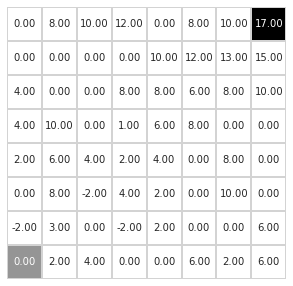

In [6]:
#Work through the steps.

soln =[(0, (6, 2)), (0, (6, 0)), (9, (5, 0))            # Make (2,7) 15 so you can complete
       ,(0, (4, 0)), (0, (3, 0)), (0, (4, 2)),
               (0, (2, 2)), (0, (3, 2)), (0, (3, 3)),
               (0,(3,1)),(0,(1,1)),(0,(1,2))            # manouver to the 11 with a 5 opposite that goes up to 7
       ,(6,(3,3)),(0,(1,2)),(0,(0,4))                   # get to a 9 without a 7 opposite
       ,(18,(1,2)),(0,(0,0))                            # get to a 7 without a 7 opposite
       ,(34,(2,1)),(0,(3,3))                            # need to keep (4,4) as 5 to be able to get to the end
       ,(40,(5,3)),(0,(5,1))                            # get to the 3 opposite the 13 to bump it up to allow the drop in the final sequence
       ,(63,(6,1)),(0,(4,0)),(0,(3,0)),(0,(4,2))        # now get out via (4,4)
       ,(0,(4,4)),(1,(3,4)),(0,(2,4)),(0,(1,4)),
               (0,(1,5)),(0,(1,6)),(0,(2,6))            # get to the 13 and then loop round via the 16 to get to 180
       ,(8,(2,7)),(0,(0,6)),(0,(1,4)),(0,(1,5)),
               (0,(1,6)),(1,(1,7)),(0,(0,7))
       ]

viz2(np.array(grd2),soln)

Score is 180. Path [(0, c2), (0, a2), (9, a3), (0, a4), (0, a5), (0, c4), (0, c6), (0, c5), (0, d5), (0, b5), (0, b7), (0, c7), (6, d5), (0, c7), (0, e8), (18, c7), (0, a8), (34, b6), (0, d5), (40, d3), (0, b3), (63, b2), (0, a4), (0, a5), (0, c4), (0, e4), (1, e5), (0, e6), (0, e7), (0, f7), (0, g7), (0, g6), (8, h6), (0, g8), (0, e7), (0, f7), (0, g7), (1, h7), (0, h8)]
Visit each cell at most 3


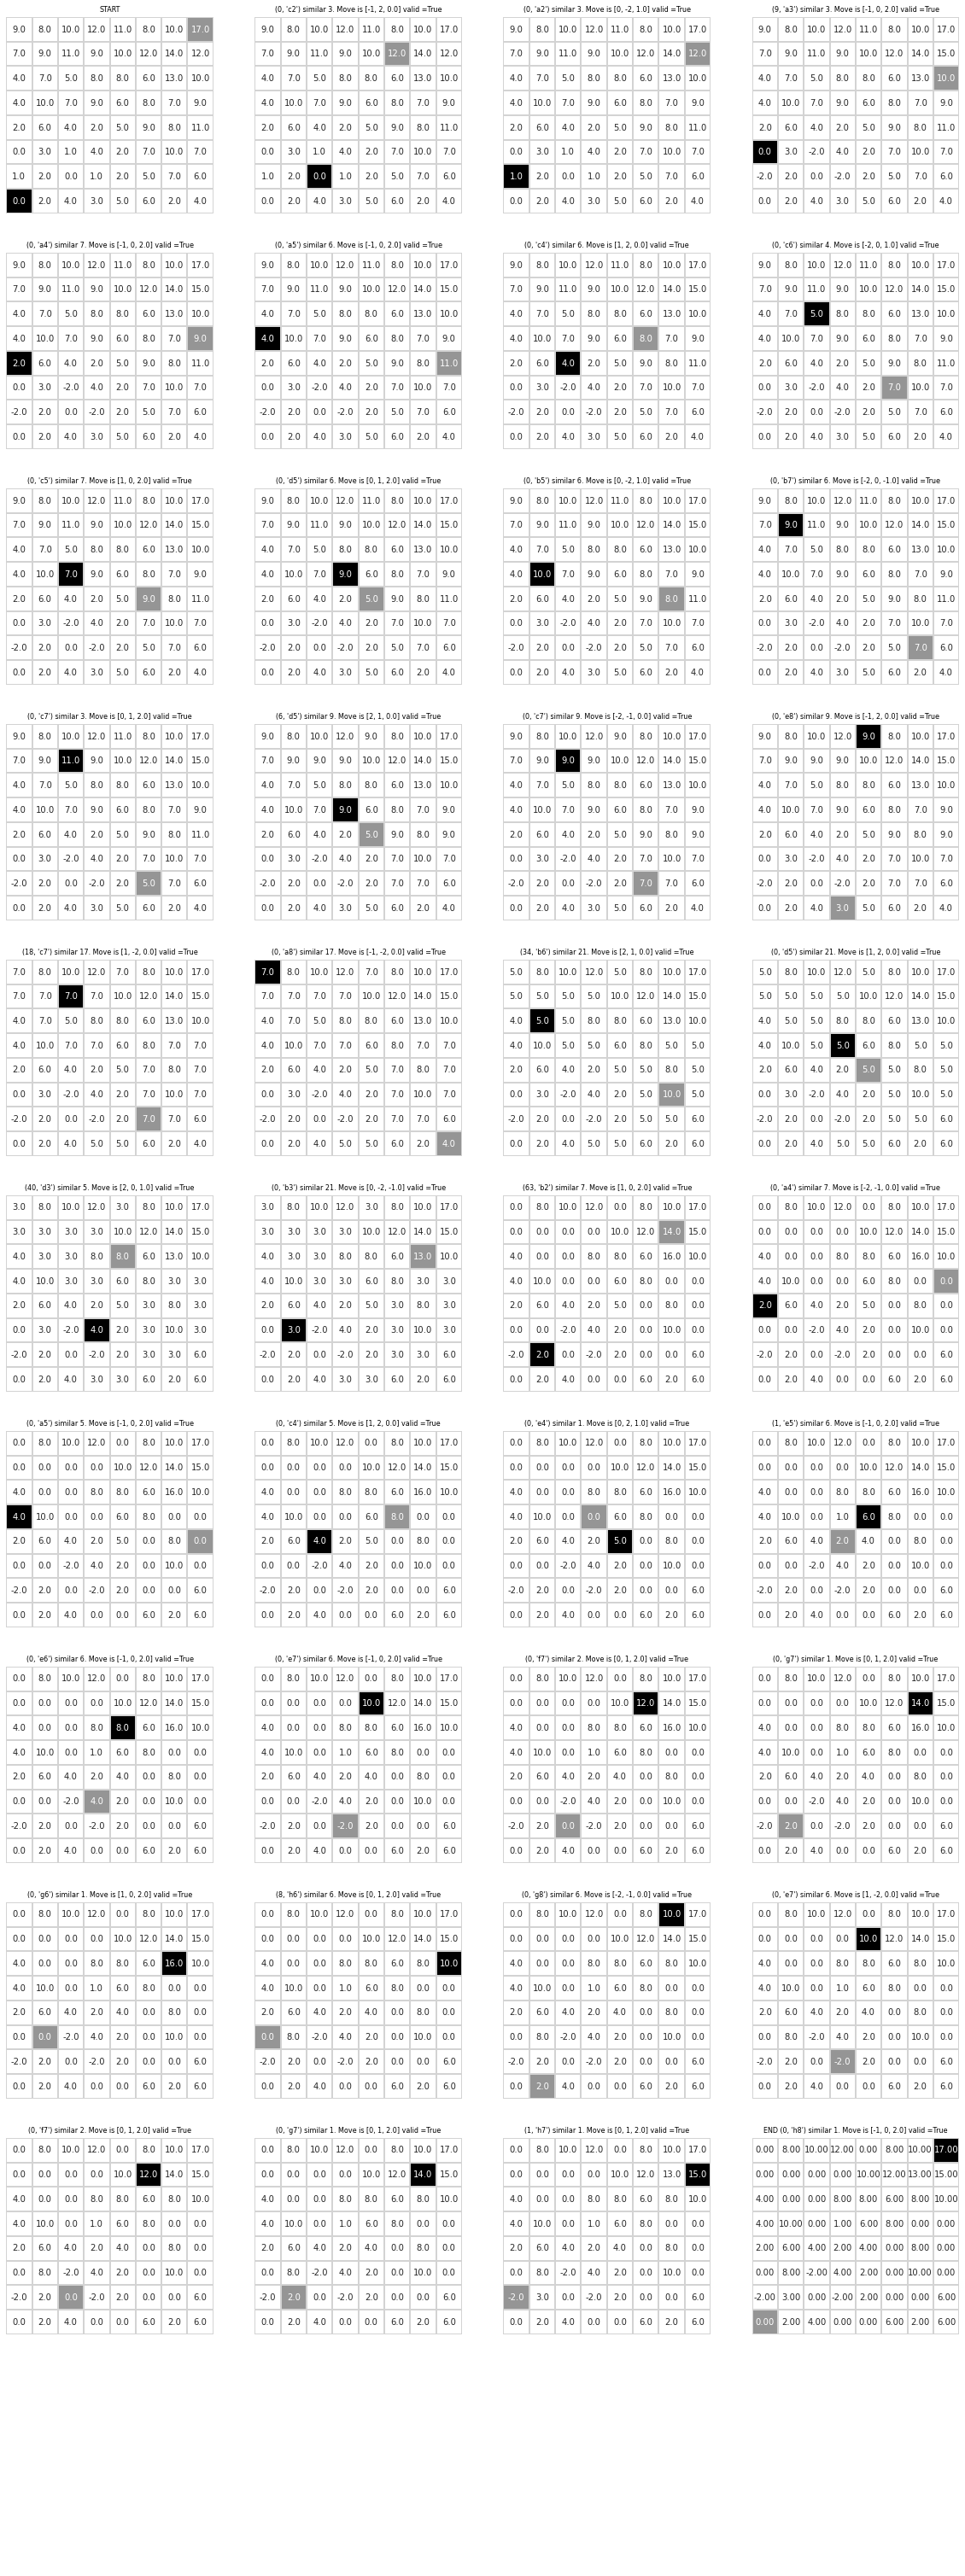

In [7]:
#Check the final solution
viz(np.array(grd2),soln)        
cols = "abcdefgh"
cells,visits = np.unique([cols[j]+str(7-i) for n,(i,j) in soln],return_counts=True)
print("Visit each cell at most {}".format(max(visits)))

In [8]:
url='https://www.janestreet.com/puzzles/knight-moves-5-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[13]+"\n"+" \n ".join(y[16:53])))
display(Image(url='https://www.janestreet.com/puzzles/20231130_knight_moves_sol.PNG',width=500))

### Knight Moves 5
This month’s puzzle was an open-ended challenge: to find a knight’s tour from a1 to h8 on a constantly shifting 3-dimensional board. 
 In the end we received a wide variety of tours. We’ll mention a few of the most interesting ones below. (Their “finishing states” are all shown above.) 
 The longest 
 1 
 valid tour came from 
 Brandon Cage 
 , which takes 
 1547 minutes 
 . 
 The second-longest 
 2 
 , at 1482 minutes, came from 
 Calvin Pozderac 
 . This tour also set the records for “lowest finishing altitude” (-32) and “longest individual sink” (364 minutes). 
 The most efficient tour 
 3 
 came from 
 Sondre Rogde 
 , who managed to get from a1 to h8 in just 
 33 jumps 
 . 
 The first tour 
 4 
 (out of just two) we received that managed to visit every point at least once came from 
 Anton 3 Terekhov 
 . 
 Those were some of our favorites, but 
 congrats to everyone who managed to find a valid tour! 
 Some open problems we were pondering: 
 What’s the longest valid tour? (Can 2000 minutes be achieved?) 
 What’s the highest possible finishing altitude? (The highest we saw was 19; could it be as high as 25?) 
 Does there exist a valid tour that does not repeat a single point? (I.e. the unclaimed “ 
 U 
 ” designation from the tourism board.) 
 Is it possible to finish a tour with every point at the same altitude? If not, what’s the largest group of same-altitude points that can be obtained? 
 Does there exist a valid tour with “max sink” < 10? (The lowest “max sink” we saw across any valid tour was 27.) 
 If you’re able to solve any of these problems, feel free to let us know! (We might update the leaderboard for especially interesting submissions.)

In [9]:
def translate(x):
    cols = "abcdefgh"
    for i in x.replace(" ","").replace("\n","").split("),"):
        yield (int(i.split(",",1)[0][1:]),
        (8-int(i.split(",",1)[1][1]),cols.index(i.split(",")[1][0])))


Score is 1547. Path [(0, b1), (0, b3), (0, c3), (0, a3), (0, a4), (0, a5), (0, c4), (0, c6), (0, b6), (0, b7), (0, c7), (3, e8), (0, f8), (0, e6), (0, e5), (0, g5), (7, f5), (0, h5), (6, h6), (0, h7), (0, g7), (3, g6), (4, e6), (0, e7), (0, f7), (9, f5), (0, e5), (0, d5), (0, c5), (0, c4), (0, d4), (0, d2), (0, c2), (0, b2), (0, b3), (16, c3), (0, c2), (0, b2), (16, c2), (12, d2), (7, e4), (0, d4), (0, c4), (0, c5), (0, d5), (0, f4), (0, h5), (0, h6), (0, g8), (0, f8), (0, e8), (0, c7), (0, e7), (0, f7), (0, g7), (0, g6), (8, g7), (4, f7), (12, e7), (2, c8), (20, d6), (0, d8), (5, b7), (28, d6), (58, f6), (10, h7), (39, g5), (47, h7), (49, f6), (0, g4), (0, h2), (0, f3), (0, h2), (0, g4), (0, f6), (0, e8), (54, c7), (0, e6), (0, f4), (0, h5), (57, g3), (0, e2), (0, c1), (126, a2), (0, c3), (0, b1), (62, d2), (0, b3), (122, c1), (0, a2), (0, b4), (120, c6), (0, d4), (0, b5), (118, a7), (0, c6), (0, a5), (116, b7), (0, c5), (0, a6), (114, b4), (0, d5), (0, b6), (56, d7), (0, b8), (110, d

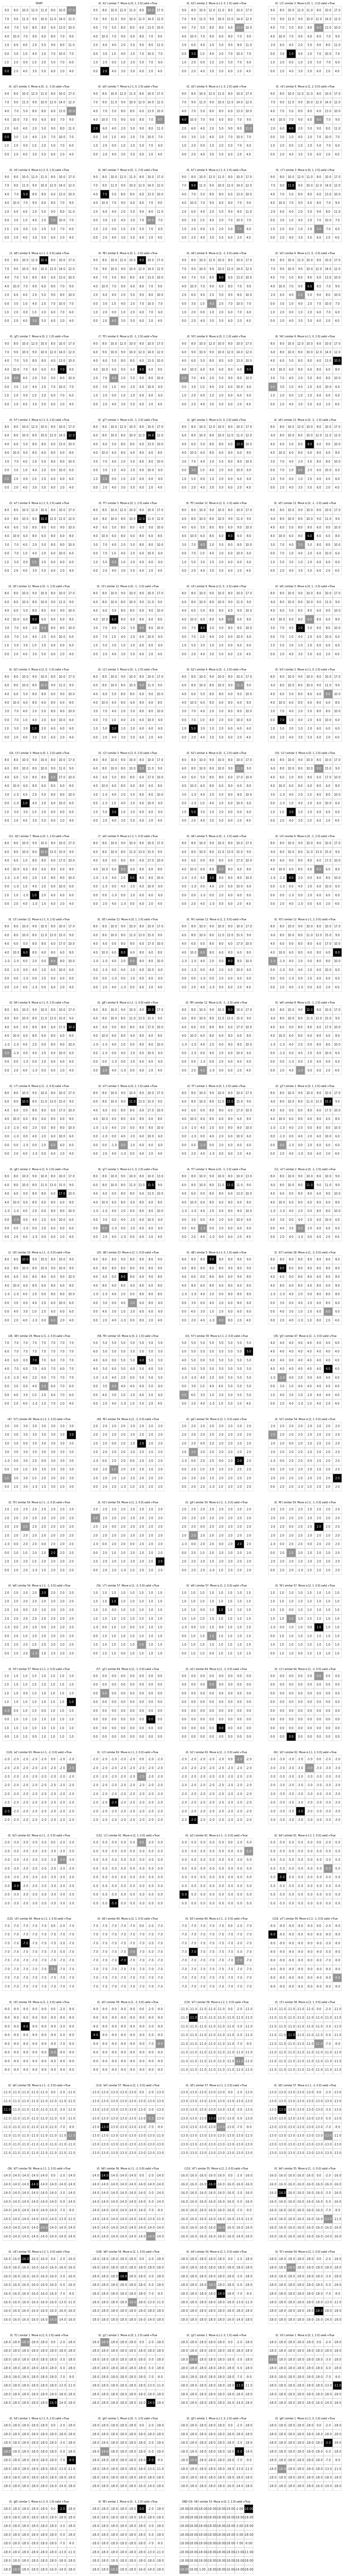

In [10]:
solution = '''(0, b1), (0, b3), (0, c3), (0, a3), (0, a4), (0, a5), (0, c4), (0, c6), (0, b6), (0, b7), (0, c7), (3, e8), (0, f8), (0, e6), (0, e5),
(0, g5), (7, f5), (0, h5), (6, h6), (0, h7), (0, g7), (3, g6), (4, e6), (0, e7), (0, f7), (9, f5), (0, e5), (0, d5), (0, c5), (0, c4), 
(0, d4), (0, d2), (0, c2), (0, b2), (0, b3), (16, c3), (0, c2), (0, b2), (16, c2), (12, d2), (7, e4), (0, d4), (0, c4), (0, c5), (0, d5), 
(0, f4), (0, h5), (0, h6), (0, g8), (0, f8), (0, e8), (0, c7), (0, e7), (0, f7), (0, g7), (0, g6), (8, g7), (4, f7), (12, e7), (2, c8), (20, d6), 
(0, d8), (5, b7), (28, d6), (58, f6), (10, h7), (39, g5), (47, h7), (49, f6), (0, g4), (0, h2), (0, f3), (0, h2), (0, g4), (0, f6), (0, e8), (54, c7), 
(0, e6), (0, f4), (0, h5), (57, g3), (0, e2), (0, c1), (126, a2), (0, c3), (0, b1), (62, d2), (0, b3), (122, c1), (0, a2), (0, b4), (120, c6), (0, d4),
(0, b5), (118, a7), (0, c6), (0, a5), (116, b7), (0, c5), (0, a6), (114, b4), (0, d5), (0, b6), (56, d7), (0, b8), (110, d7), (0, b6), (0, c8), (108, d6), 
(0, e4), (0, f2), (0, f1), (0, g1), (0, g3), (0, h3), (0, h4), (0, g4), (0, g5), (0, g6), (0, g8), (0, f8), (19, h8) '''

viz(np.array(grd2),[x for x in translate(solution)])

Score is 1482. Path [(0, b1), (0, c1), (30, a1), (0, b1), (35, c1), (6, c2), (3, a1), (0, c1), (18, d3), (0, d4), (0, c4), (0, a5), (0, a4), (0, a3), (0, c2), (0, d2), (0, d1), (0, e1), (4, f1), (5, h2), (0, h3), (7, g5), (0, f3), (14, f1), (60, h2), (0, h1), (0, g1), (0, e2), (0, d4), (0, c4), (0, a5), (0, a4), (0, a3), (0, c2), (0, d2), (0, d1), (2, e1), (0, f3), (0, g5), (0, e4), (0, c5), (0, c6), (0, d6), (5, d7), (6, e7), (0, c7), (16, c5), (0, c6), (1, d6), (5, f5), (0, f3), (2, h4), (3, h3), (0, g5), (0, g4), (0, f4), (0, h5), (0, h6), (0, h7), (0, f7), (24, d8), (0, d6), (0, d5), (0, f4), (0, h5), (0, h6), (0, h7), (0, g7), (1, g8), (0, f8), (14, e8), (12, f8), (12, h7), (45, f8), (19, g6), (364, f6), (20, f7), (112, f6), (20, f7), (112, f6), (20, g6), (112, f4), (0, h3), (0, h2), (5, f2), (27, e4), (26, g3), (25, h5), (0, g3), (0, e4), (0, c5), (0, d5), (0, e5), (24, d5), (1, b6), (9, b5), (116, b6), (12, b5), (116, a7), (0, b5), (0, b6), (12, b7), (0, d8), (0, c6), (0, e7), (

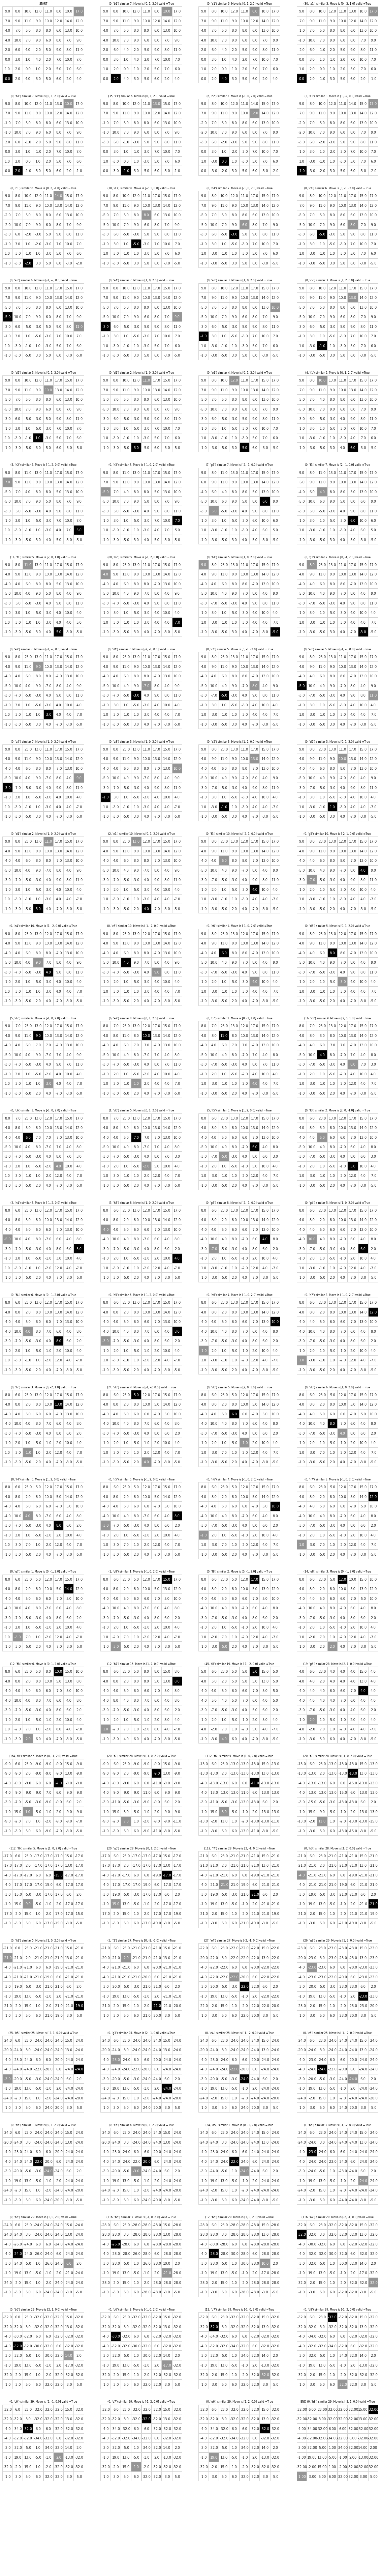

In [11]:
solution = '''(0, b1), (0, c1), (30, a1), (0, b1), (35, c1), (6, c2), (3, a1), (0, c1), (18, d3), (0, d4), (0, c4), (0, a5), (0, a4),
(0, a3), (0, c2), (0, d2), (0, d1), (0, e1), (4, f1), (5, h2), (0, h3), (7, g5), (0, f3), (14, f1), (60, h2), (0, h1), (0, g1), (0, e2),
(0, d4), (0, c4), (0, a5), (0, a4), (0, a3), (0, c2), (0, d2), (0, d1), (2, e1), (0, f3), (0, g5), (0, e4), (0, c5), (0, c6), (0, d6), 
(5, d7), (6, e7), (0, c7), (16, c5), (0, c6), (1, d6), (5, f5), (0, f3), (2, h4), (3, h3), (0, g5), (0, g4), (0, f4), (0, h5), (0, h6),
(0, h7), (0, f7), (24, d8), (0, d6), (0, d5), (0, f4), (0, h5), (0, h6), (0, h7), (0, g7), (1, g8), (0, f8), (14, e8), (12, f8), (12, h7), 
(45, f8), (19, g6), (364, f6), (20, f7), (112, f6), (20, f7), (112, f6), (20, g6), (112, f4), (0, h3), (0, h2), (5, f2), (27, e4), (26, g3),
(25, h5), (0, g3), (0, e4), (0, c5), (0, d5), (0, e5), (24, d5), (1, b6), (9, b5), (116, b6), (12, b5), (116, a7), (0, b5), (0, b6), (12, b7), 
(0, d8), (0, c6), (0, e7), (0, g6), (0, h8) '''

viz(np.array(grd2),[x for x in translate(solution)])

Score is 199. Path [(0, b1), (0, b3), (0, c3), (0, a2), (9, a3), (0, a4), (0, a5), (0, c4), (0, b4), (0, b6), (0, b7), (0, c7), (6, a8), (18, b6), (0, d5), (0, f4), (0, g2), (0, h4), (0, f3), (68, d3), (0, b3), (95, a3), (0, a4), (0, a5), (0, c4), (0, e4), (2, e5), (0, e6), (0, e7), (0, f7), (0, g7), (1, h7), (0, h8)]


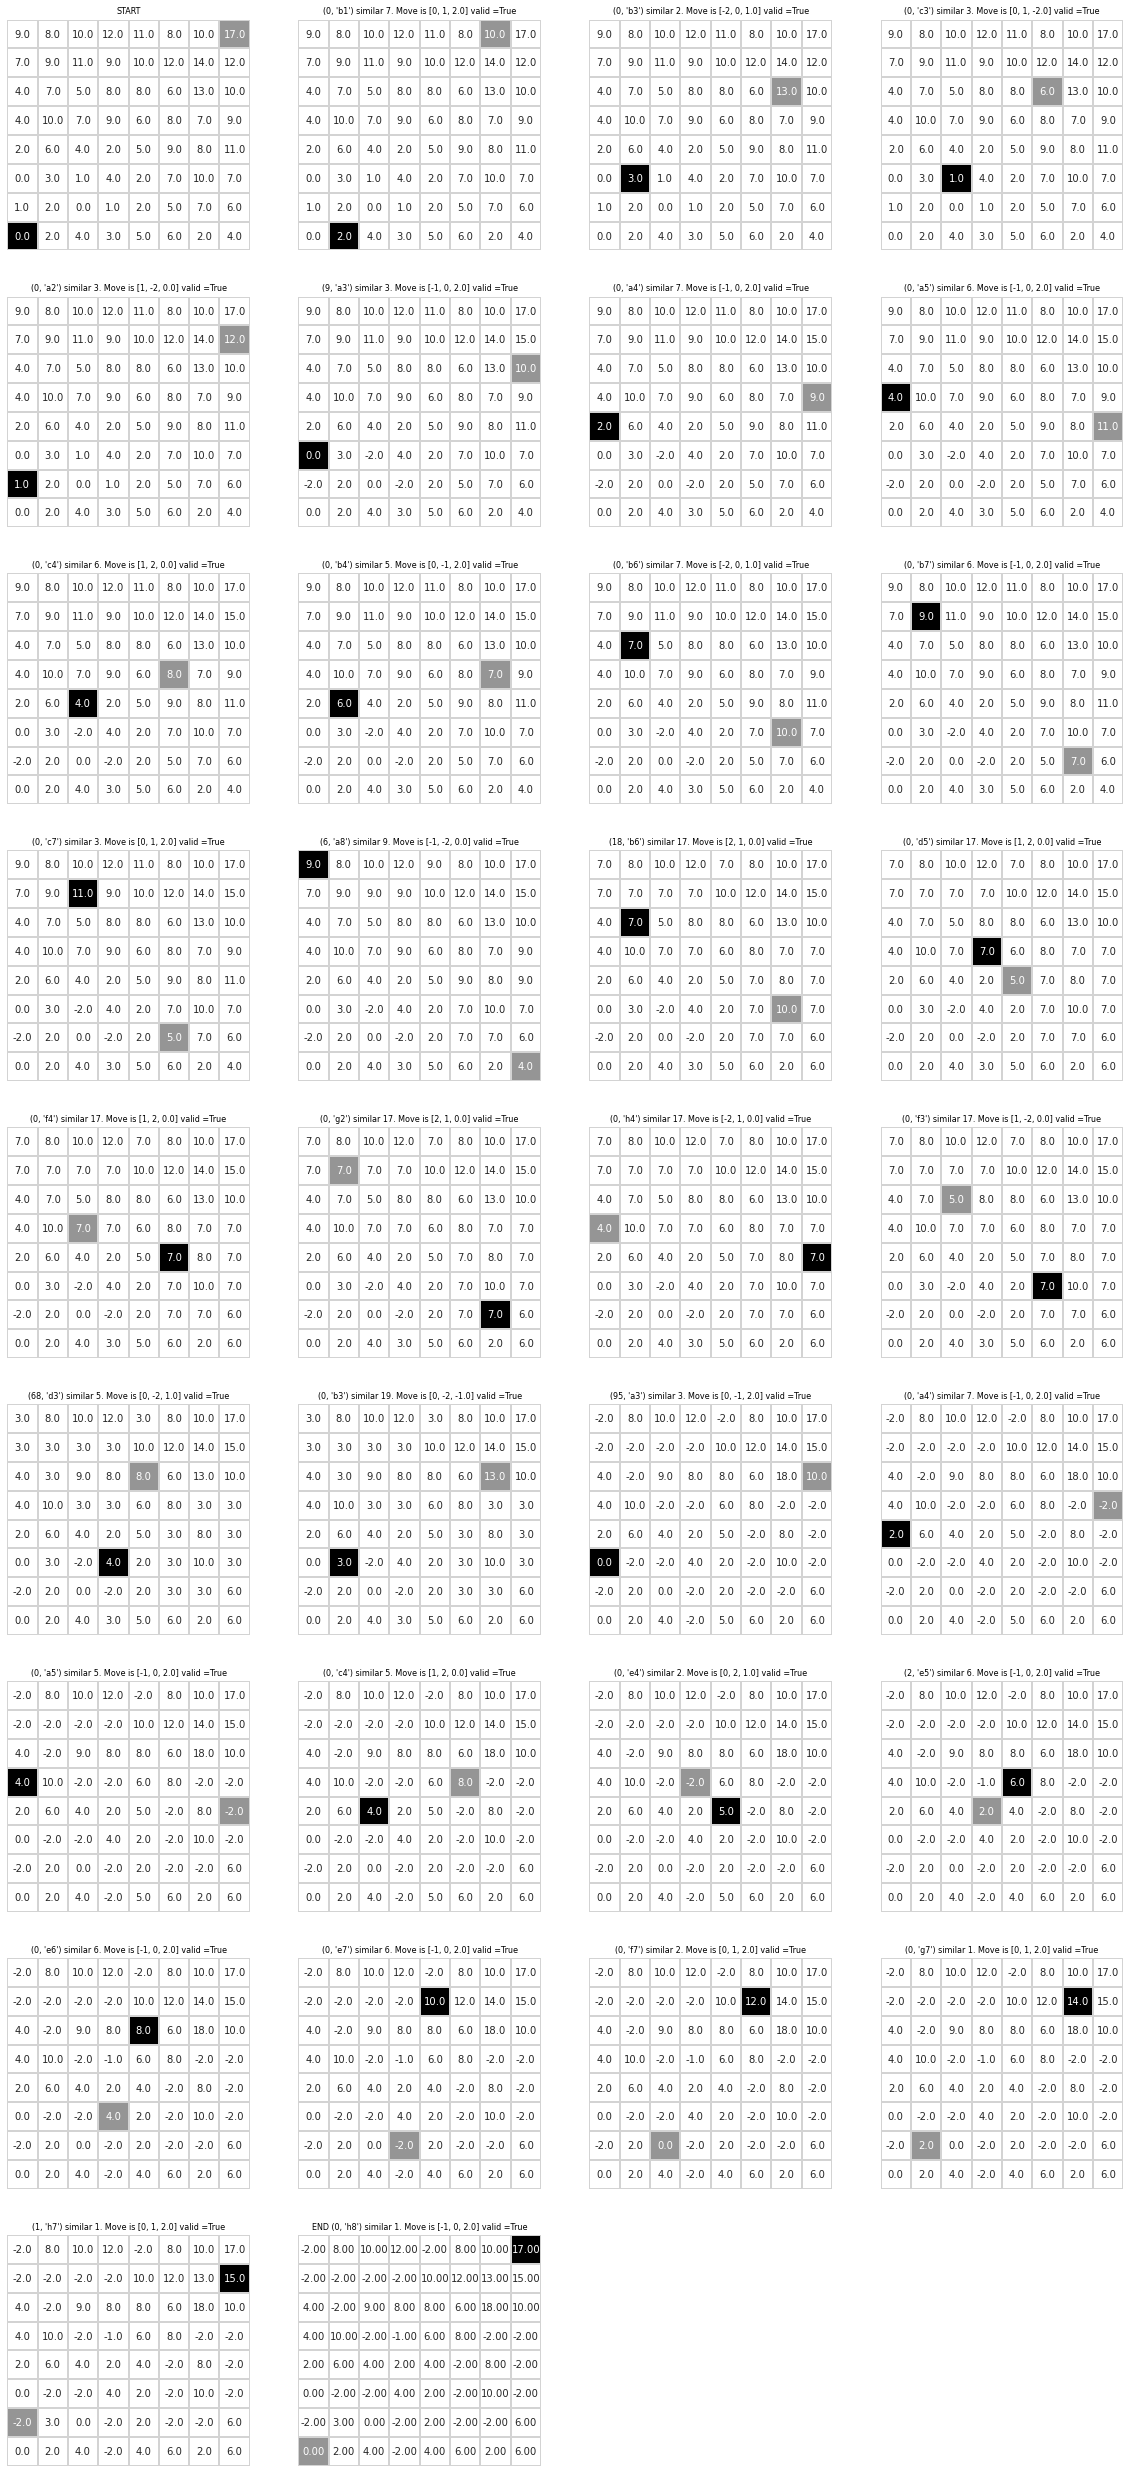

In [12]:
solution = '''(0, b1), (0, b3), (0, c3), (0, a2), (9, a3), (0, a4), (0, a5), (0, c4), (0, b4), (0, b6), (0, b7), (0, c7), (6, a8),
(18, b6), (0, d5), (0, f4), (0, g2), (0, h4), (0, f3), (68, d3), (0, b3), (95, a3), (0, a4), (0, a5), (0, c4), (0, e4), (2, e5), (0, e6),
(0, e7), (0, f7), (0, g7), (1, h7), (0, h8) '''

viz(np.array(grd2),[x for x in translate(solution)])

Score is 417. Path [(0, b1), (0, b3), (8, c3), (0, e3), (0, d3), (0, d4), (0, c4), (0, e4), (0, f2), (0, f3), (0, g5), (0, h5), (6, h3), (0, g5), (0, e5), (0, c5), (0, c6), (0, a6), (0, a4), (3, a2), (0, c3), (0, e3), (0, d3), (0, d4), (0, c4), (0, b4), (40, a4), (0, a2), (0, c2), (0, b2), (0, d2), (0, d4), (0, c4), (0, c6), (0, b6), (0, b8), (0, c8), (0, d8), (0, f7), (0, g7), (0, g5), (0, g6), (10, g7), (2, g8), (0, h6), (0, g6), (6, h4), (10, g4), (0, h4), (32, f5), (54, f3), (7, h4), (0, g2), (0, f4), (70, f2), (4, h1), (0, g1), (0, e2), (0, e1), (42, g1), (0, g3), (0, e4), (0, d6), (0, b7), (0, c7), (0, c5), (1, b5), (0, a7), (0, c8), (0, e7), (0, d5), (120, e5), (0, e6), (0, f6), (0, f5), (0, g3), (0, h1), (0, h2), (0, f1), (0, d1), (0, d3), (0, c1), (0, c3), (0, a3), (0, b5), (0, b4), (0, b3), (0, a5), (0, b3), (0, a1), (0, c2), (0, e1), (0, e2), (0, e4), (2, e6), (0, f8), (0, h7), (0, f8), (0, d7), (0, b6), (0, a8), (0, b6), (0, c8), (0, d6), (0, e8), (0, d6), (0, f7), (0, h8)]

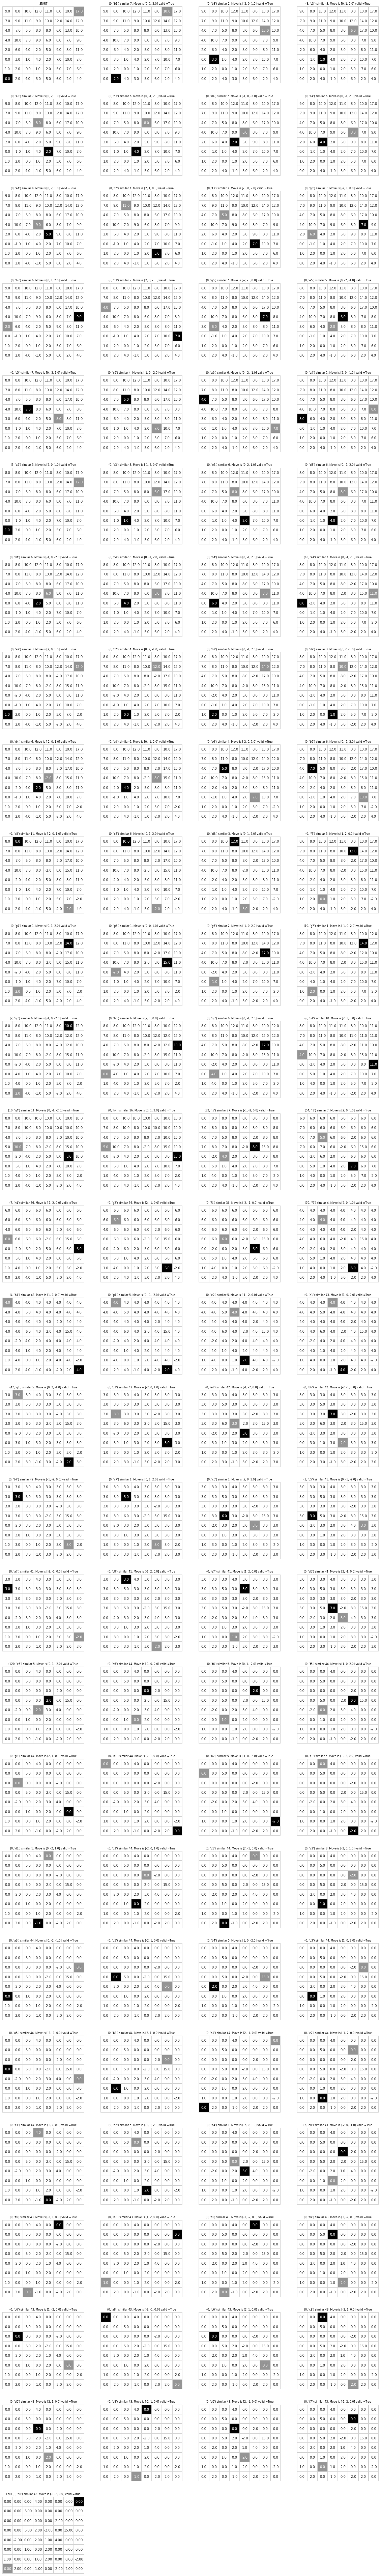

In [13]:
solution = '''(0, b1), (0, b3), (8, c3), (0, e3), (0, d3), (0, d4), (0, c4), (0, e4), (0, f2), (0, f3), (0, g5), (0, h5), (6, h3),
(0, g5), (0, e5), (0, c5), (0, c6), (0, a6), (0, a4), (3, a2), (0, c3), (0, e3), (0, d3), (0, d4), (0, c4), (0, b4), (40, a4), (0, a2),
(0, c2), (0, b2), (0, d2), (0, d4), (0, c4), (0, c6), (0, b6), (0, b8), (0, c8), (0, d8), (0, f7), (0, g7), (0, g5), (0, g6), (10, g7),
(2, g8), (0, h6), (0, g6), (6, h4), (10, g4), (0, h4), (32, f5), (54, f3), (7, h4), (0, g2), (0, f4), (70, f2), (4, h1), (0, g1), (0, e2),
(0, e1), (42, g1), (0, g3), (0, e4), (0, d6), (0, b7), (0, c7), (0, c5), (1, b5), (0, a7), (0, c8), (0, e7), (0, d5), (120, e5), (0, e6),
(0, f6), (0, f5), (0, g3), (0, h1), (0, h2), (0, f1), (0, d1), (0, d3), (0, c1), (0, c3), (0, a3), (0, b5), (0, b4), (0, b3), (0, a5), (0, b3),
(0, a1), (0, c2), (0, e1), (0, e2), (0, e4), (2, e6), (0, f8), (0, h7), (0, f8), (0, d7), (0, b6), (0, a8), (0, b6), (0, c8), (0, d6), (0, e8),
(0, d6), (0, f7), (0, h8) '''

viz(np.array(grd2),[x for x in translate(solution)])